This notebook is designed to find optimal segmentation parameters for a series of images

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, core, io, plot, transforms
from natsort import natsorted
from pathlib import Path
from tqdm import trange
import tifffile

In [8]:
if not core.use_gpu():
    model = models.CellposeModel(gpu = False)
    raise ImportError("No GPU access detected.") 
else:
    model = models.CellposeModel(gpu = True)

These are the parameters that will need to be modified across each image.

`FLOW_THRESHOLD` is the maximum allowed error of the flows for each mask. Default == 0.4.
* **Increase** this threshold if there are not as many masks as you’d expect (or turn off completely with 0.0)
* **Decrease** this threshold if there are too many ill-shaped masks.

`CELLPROB_THRESHOLD` determines proability that a detected object is a cell. Default == 0.0.
* **Increase** this threshold if there are too many masks, especiallly from dull/dim areas.
* **Decrease** this threshold if there are not as many masks as you’d expect or if masks are too small

`NITER` is the number of iterations for dynamics involved in mask creation. A default value of 0 means it is proportional to diameter. If you have long ROIs, set to a larger number like 2000.

`TILE_NORM_BLOCKSIZE` determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together. You may want to change this to 100-200 pixels if you have inhomogeneous brightness across your image.

`BATCH_SIZE` is number of images loaded and run through the model at the same time. For example, if you set `batch_size = 8`, it will take 8 images, stack them into a batch, and send them through the network together.

`CHANNELS` is used to select which channels you want to use in the segmentation. This can be a phase, brightfield, or nuclear stain etc. When using more than 1 channel, order does not matter.

In [ ]:
# Parameters to change!

# Directory containing images to process
IMAGE_DIR = "/path/goes/here"
IMAGE_EXTENSION = ".tif"  # Change this to your image file extension

# Segmentation parameters
FLOW_THRESHOLD = 1
CELLPROB_THRESHOLD = 0
NITER = 5000
TILE_NORM_BLOCKSIZE = 500
BATCH_SIZE = 8

# Channel selection (modify this list as needed)
CHANNELS = [0]  # List of channel indices to use, e.g., [0], [0, 1], [0, 1, 2], etc.

TIMEPOINT = 10

Found 240 image files to process

TESTING ON SINGLE IMAGE


100%|██████████| 318/318 [00:00<00:00, 903.80it/s]


Image: VID186_N22_1.tif
Timepoint: 10
Raw image shape: (3, 1040, 1408)
Channels: [0]
Processed image shape: (944, 1280, 1)
Running segmentation...
Found 14 cell(s)


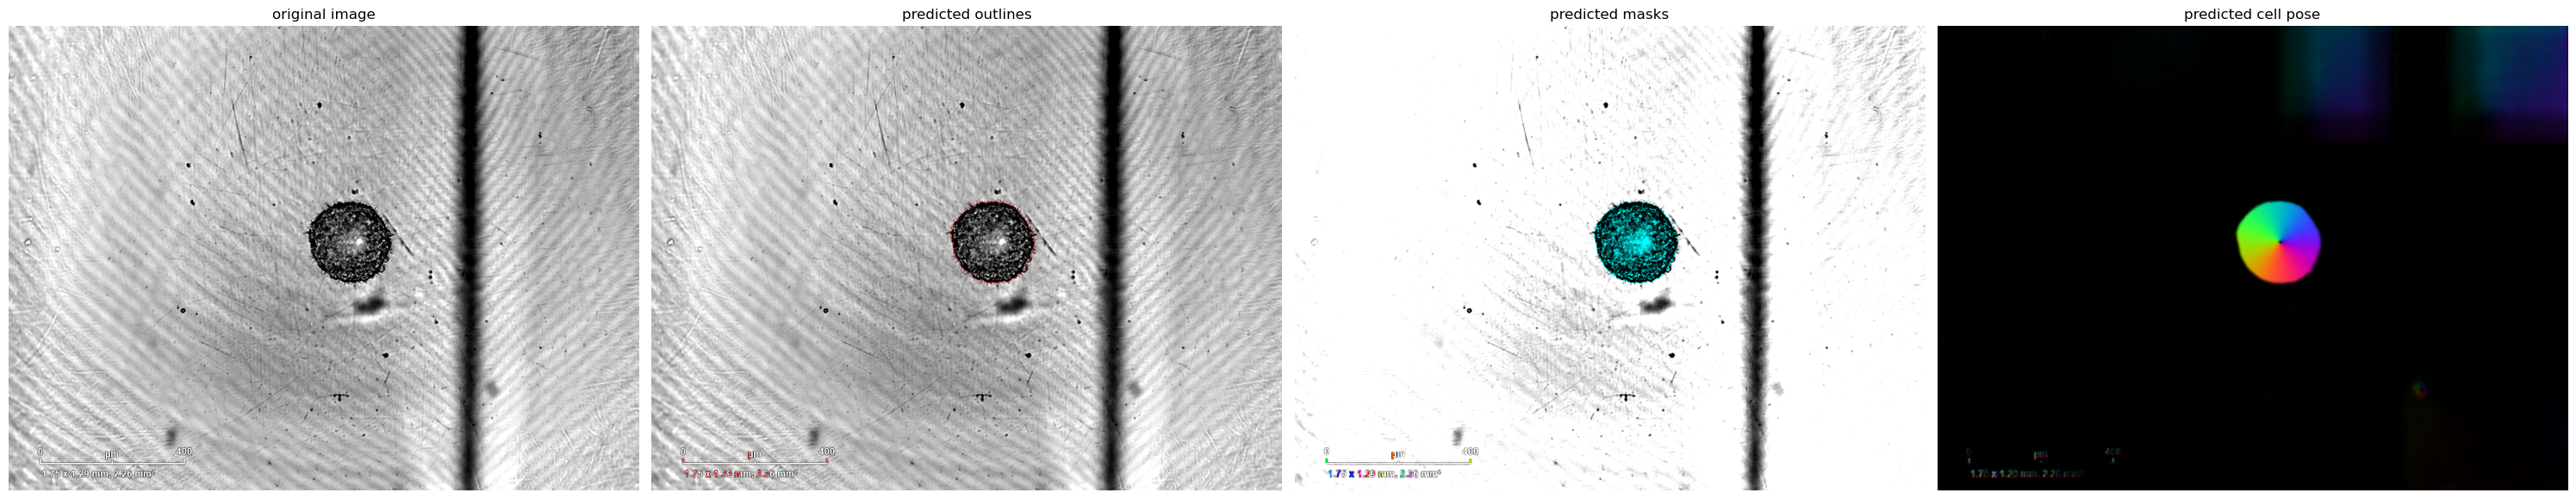

In [12]:
# Setup directory path
image_dir = Path(IMAGE_DIR)
if not image_dir.exists():
    raise FileNotFoundError(f"Directory does not exist: {IMAGE_DIR}")

# Find all image files (excluding masks and flows)
image_files = natsorted([
    f for f in image_dir.glob(f"*{IMAGE_EXTENSION}") 
    if "_masks" not in f.name and "_flows" not in f.name
])
image_files

if not image_files:
    raise FileNotFoundError(f"No {IMAGE_EXTENSION} files found in {IMAGE_DIR}")

print(f"Found {len(image_files)} image files to process")

print("\n" + "="*50)
print("TESTING ON SINGLE IMAGE")
print("="*50)

# Load and preprocess test image using last image
test_idx = len(image_files) - 1
if test_idx >= len(image_files):
    test_idx = 0
    
test_file = image_files[test_idx]

img = io.imread(test_file)

print(f"Image: {test_file.name}")

with tifffile.TiffFile(test_file) as tif:
        # Check for axes information in metadata
        if hasattr(tif.series[0], 'axes'):
            axes = tif.series[0].axes
            axis_map = {ax: i for i, ax in enumerate(axes)}
            if 'T' in axis_map:
                # print(f"TIME SERIES IMAGE DETECTED")
                print(f"Timepoint: {TIMEPOINT}")
                img = np.take(img, TIMEPOINT, axis=axis_map['T'])
            else:
                img = transforms.move_min_dim(img)
        else:
            img = transforms.move_min_dim(img)
                
img = transforms.normalize_img(img, normalize=True, percentile=(1, 99))

print(f"Raw image shape: {img.shape}")
# print(f"Assuming channel dimension is last with {img.shape[-1]} channels")

# Select channels for processing
print(f"Channels: {CHANNELS}")

# Validate channel indices
max_channel = img.shape[-1] - 1
for ch in CHANNELS:
    if ch > max_channel:
        raise ValueError(f"Channel index {ch} exceeds available channels (0-{max_channel})")

if 'C' in axis_map:
    img = np.take(img, CHANNELS, axis=axis_map['C'])
else:
    img_processed = img[..., CHANNELS]

print(f"Processed image shape: {img_processed.shape}")

# Run segmentation on test image
print("Running segmentation...")
masks, flows, styles = model.eval(
    img_processed, 
    batch_size = BATCH_SIZE,
    flow_threshold = FLOW_THRESHOLD,
    cellprob_threshold = CELLPROB_THRESHOLD,
    normalize = {"tile_norm_blocksize": TILE_NORM_BLOCKSIZE},
    niter = NITER
)

print(f"Found {len(np.unique(masks))-1} cell(s)")

# Visualize results
fig = plt.figure(figsize = (30, 12))
plot.show_segmentation(fig, img_processed, masks, flows[0])
plt.tight_layout()
plt.show()